In [76]:
def readText(path):
    with open(path) as f:
        captions=f.read()
    return captions
captions=readText("Downloads/DATA606-data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
print(len(captions))

3395237


In [77]:
#!pip install opencv-python


In [78]:
#Discarding last line as it is empty
captions=captions.split("\n")[:-1]


In [79]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [80]:
len(captions)

40460

In [81]:
#Since each image has no of captions now we create a dictionary where each image will be mapped to its list of captions
descriptions={}
for x in captions:
    first,second=x.split("\t")
    img_name=first.split(".")[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]

    descriptions[img_name].append(second)

In [82]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

(0.0, 1.0, 0.0, 1.0)

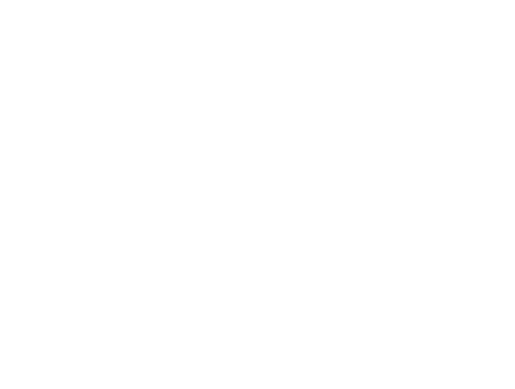

In [83]:
IMG_PATH="Downloads/DATA606-data/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt
#IMG_PATH=IMG_PATH+"1000268201_693b08cb0e.jpg"
#print(IMG_PATH)
img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#plt.imshow(img)
plt.axis("off")
#plt.show()


DATA CLEANING


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input,decode_predictions
#from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
#from keras.layers.merge import add
from tensorflow.keras.layers import concatenate,add



In [85]:
#ANything that is not an alphabet is replaced with space. Reducing Vocab
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    #removing sentences whose length is less than 1
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence


In [86]:
clean_text("a cat sitting 64")

'cat sitting'

In [87]:
#cleaning all captions

for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        
    

In [88]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [89]:
#write data to  text file since data is large and work on file directly
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

Vocabulary



In [90]:
descriptions=None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()
#since this is in string format we convert this to dict
s=descriptions.replace("'","\"")
descriptions=json.loads(s)
print(type(descriptions))

<class 'dict'>


In [91]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [92]:
#total no of words across all sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words %d"%len(total_words))

Total words 373837


In [93]:
#total words are 373837 and unique words are 8424
#filter words according to certain threshold
import collections
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(freq_cnt)
print(len(freq_cnt))

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [94]:
#sort dictionary according to freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [95]:
print(len(total_words))

1845


In [96]:
#train.txt has all image names that should be in training set
#prepare train and test data
#train_file_data=readTextFile("Downloads/DATA606-data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train_file_data = open('Downloads/DATA606-data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt','r')
train=train_file_data.readlines()
test_file_data = open('Downloads/DATA606-data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt','r')
test=test_file_data.readlines()

In [97]:
train=[i[:-5] for i in train ]
test=[i[:-5] for i in test]


In [98]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [99]:
train[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

In [100]:
#prepare descriptions for train data
#add <s> and <e> token to our training data
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq "+cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [101]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [102]:
len(train_descriptions)

6000

Transfer Learning



Images -> Features


Text-> Features


STEP 1 - IMAGE FEATURE EXTRACTION

In [103]:
model=ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [104]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [105]:
model_new=Model(model.input,model.layers[-2].output)   #-2 for taking GlobalAveragePooling



In [106]:
from keras.utils import load_img, img_to_array 
def preprocess_img(img):
    img=load_img(img,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #normaliztion
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


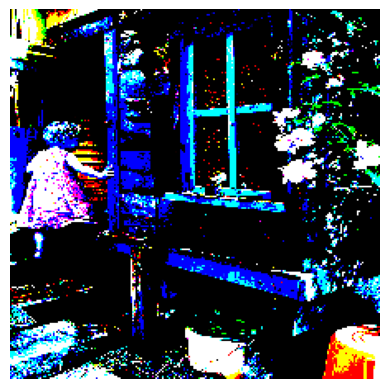

In [107]:

img=preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()


In [108]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector =model_new.predict(img)
    
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector
    

In [109]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 1s 1s/step


array([0.06535926, 0.16782555, 0.3251761 , ..., 0.05107139, 0.32821193,
       1.0043361 ], dtype=float32)

In [110]:
import pickle

# Open the file in binary mode
with open("encoded_test_feature.pkl", "rb") as f:
    # Load the object from the file
    encoding_test = pickle.load(f)

    


In [111]:
import pickle

# Open the file in binary mode
with open("encoded_train_feature.pkl", "rb") as f:
    # Load the object from the file
    encoding_train = pickle.load(f)

    


In [112]:
'''
start=time()
encoding_train={}
#image_id -> feature_vector  extarcted  from Resnet Image
for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix % 100 == 0:
        print("Encoding  in progress Time step %d"%ix)
end_t=time()
print("Total  time",end_t - start)
print(len(encoding_train))
'''

'\nstart=time()\nencoding_train={}\n#image_id -> feature_vector  extarcted  from Resnet Image\nfor ix,img_id in enumerate(train):\n    img_path=IMG_PATH+"/"+img_id+".jpg"\n    encoding_train[img_id] = encode_image(img_path)\n    if ix % 100 == 0:\n        print("Encoding  in progress Time step %d"%ix)\nend_t=time()\nprint("Total  time",end_t - start)\nprint(len(encoding_train))\n'

In [113]:
#store to disk to avoid long running
'''with open("encoded_train_feature.pkl","wb") as f:
    pickle.dump(encoding_train,f)
  '''

'with open("encoded_train_feature.pkl","wb") as f:\n    pickle.dump(encoding_train,f)\n  '

In [114]:
'''
start=time()
encoding_test={}
#image_id -> feature_vector  extarcted  from Resnet Image
for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix % 100 == 0:
        print("Encoding  in progress Time step %d"%ix)
end_t=time()
print("Total  time",end_t - start)
'''

'\nstart=time()\nencoding_test={}\n#image_id -> feature_vector  extarcted  from Resnet Image\nfor ix,img_id in enumerate(test):\n    img_path=IMG_PATH+"/"+img_id+".jpg"\n    encoding_test[img_id] = encode_image(img_path)\n    if ix % 100 == 0:\n        print("Encoding  in progress Time step %d"%ix)\nend_t=time()\nprint("Total  time",end_t - start)\n'

In [115]:
'''#store to disk to avoid long running
with open("encoded_test_feature.pkl","wb") as f:
    pickle.dump(encoding_test,f)
'''

'#store to disk to avoid long running\nwith open("encoded_test_feature.pkl","wb") as f:\n    pickle.dump(encoding_test,f)\n'

In [116]:
encoding_train['2513260012_03d33305cf']

array([0.34708002, 0.5115907 , 0.08728839, ..., 1.1897295 , 0.04043845,
       0.1527107 ], dtype=float32)

data preprocessing for captions


In [117]:
len(total_words)

1845

In [118]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [119]:
word_to_idx["dog"]

6

In [120]:
#manually add two special words
idx_to_word[1846]='startseq'
word_to_idx['startseq'] = 1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847
vocab_size=len(word_to_idx)+1
print("vocab size",vocab_size)

vocab size 1848


In [121]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

35


DATA LOADER (Generator)

In [122]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            print(n)
            #photo=encoding_train[key+".jpg"]
            photo=encoding_train[key]
            print(n)
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx ]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y=[],[],[]
                    n=0                 

 WORD EMBEDDING

In [123]:
f=open("C:/Users/diksh/Downloads/DATA606-data/Flickr_Data/Flickr_Data/glove.6B.50d.txt",encoding='utf8' )

In [124]:
embedding_index={}
for line in f:
    values = line.split()
    print(values)
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['dào', '-0.34753', '-0.12654', '-0.036263', '-0.13663', '-0.65058', '-1.01', '1.3011', '0.36457', '-0.29005', '-0.12571', '-0.17402', '0.7618', '0.81714', '0.37556', '-0.10744', '-0.51259', '0.13345', '0.47033', '0.85059', '0.14197', '-0.48677', '-0.57025', '0.037643', '0.72087', '1.3497', '1.0516', '-0.24919', '-0.048712', '0.58848', '-0.34051', '-0.85826', '-0.13764', '-0.24887', '0.77687', '-0.92713', '0.14574', '-0.040994', '-0.62959', '-0.3553', '0.10676', '0.36469', '-0.70496', '0.77779', '-0.27966', '0.30945', '-0.031626', '0.72232', '-0.04097', '0.8124', '0.67663']
['zisi', '-0.55469', '-0.69152', '0.35232', '-0.59746', '0.071319', '-0.16297', '0.1041', '0.62268', '-0.32949', '0.2923', '-0.030544', '-0.24133', '0.38756', '0.15635', '-0.12165', '0.01695', '-0.38695', '-0.24862', '0.56392', '-0.1444', '-0.23573', '0.52068', '-0.22941', '-0.035828', '0.90204', '0.78955', '0.16587', '0.056141', '0.33232', '-0.25587', '-1.5137', '0.033553', '0.082463', '0.13117', '-0.29331', '-0.08

In [125]:
f.close()

In [126]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [127]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [128]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

MODEL ARCHITECTURE


In [129]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [130]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [131]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [132]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [133]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False


In [134]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [135]:
epochs=20
batch_size=3
steps=len(train_descriptions)//batch_size


In [136]:
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')
        

In [137]:
#train()

In [138]:
model=load_model('./model_weights/model_19.h5')


In [139]:

def predict_caption(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax()
        
        word=idx_to_word[ypred]
        in_text+=(' '+word)
        if word == 'endseq':
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption
            

1/1 [==============================] - 0s 63ms/step
girl in bathing suit is jumping into swimming pool
1/1 [==============================] - 0s 62ms/step
boy in red shirt is jumping off swing
1/1 [==============================] - 0s 52ms/step
dog jumps into the air to catch frisbee
1/1 [==============================] - 0s 55ms/step
surfer rides his board through the water
1/1 [==============================] - 0s 50ms/step
dog is running through the grass
1/1 [==============================] - 0s 57ms/step
the little girl is sitting on the seat of the slide
1/1 [==============================] - 0s 31ms/step
two dogs are running through the grass
1/1 [==============================] - 0s 47ms/step
man in black shirt and jeans walks on the sidewalk
1/1 [==============================] - 0s 43ms/step
man in black shirt and tie hat is standing in front of
1/1 [==============================] - 0s 45ms/step
man in red shirt is sitting on the curb of jeep
1/1 [===========================

1/1 [==============================] - 0s 45ms/step
two children are wearing red and red make down snowy hill


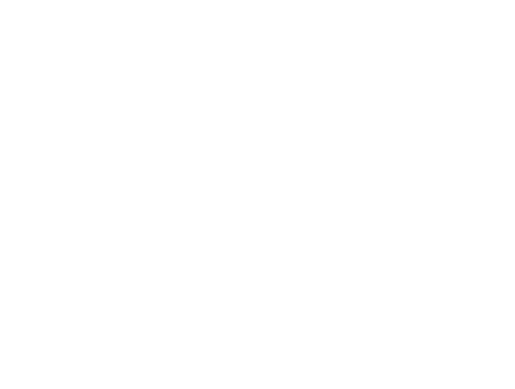

In [140]:

max_len=35
for i in range(15):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))
    i=plt.imread("Downloads/DATA606-data/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    caption=predict_caption(photo_2048)
    print(caption)
    #plt.imshow(i)
    plt.axis("off")
    #plt.show()
 
   

In [ ]:
from flask import Flask, request, render_template
import tensorflow as tf
from PIL import Image
import numpy as np
from io import BytesIO
import base64


app = Flask(__name__, template_folder='C:/Users/diksh/OneDrive/Desktop/templates')

# Load the pre-trained model
#model = tf.keras.models.load_model('model.h5')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    
    # Open the image file using Pillow
    file = request.files['image']
    img = Image.open(file)
    img_bytes = BytesIO()
    img.save(img_bytes, format='JPEG')

    # Encode the image into a feature vector
    d = encode_image(img_bytes)
    d1 = d.reshape((1, 2048))

    # Generate the caption for the image
    caption = predict_caption(d1)

    # Convert the image to a base64 string for embedding in HTML
    img_base64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
    
    # Return the prediction to the user
    return render_template('result.html', caption=caption, img_base64=img_base64)


if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/May/2023 15:33:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/May/2023 15:33:39] "GET /favicon.ico HTTP/1.1" 404 -
